In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

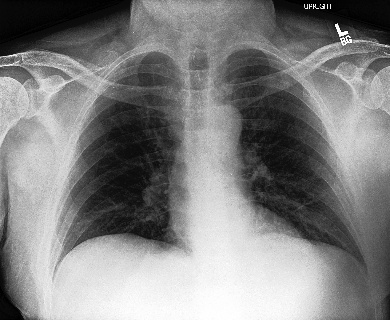

In [3]:
from PIL import Image
Image.open("../input/chexpert/CheXpert-v1.0-small/valid/patient64563/study1/view1_frontal.jpg")

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
DATA_DIR = '../input/data/'
image_size = 256
batch_size = 32

## Data preprocessing

### Preprocessing Metadata

In [6]:
df = pd.read_csv(f'{DATA_DIR}Data_Entry_2017.csv')

In [7]:
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', '*', '*.png'))}

In [8]:
df['path'] = df['Image Index'].map(data_image_paths.get)

In [9]:
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

In [10]:
labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x) > 0]

In [11]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [12]:
for label in labels:
    if len(label) > 1:
        df[label] = df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0.0)

In [13]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df['path']

0         ../input/data/images_001/images/00000001_000.png
1         ../input/data/images_001/images/00000001_001.png
2         ../input/data/images_001/images/00000001_002.png
3         ../input/data/images_001/images/00000002_000.png
4         ../input/data/images_001/images/00000003_000.png
                                ...                       
112115    ../input/data/images_012/images/00030801_001.png
112116    ../input/data/images_012/images/00030802_000.png
112117    ../input/data/images_012/images/00030803_000.png
112118    ../input/data/images_012/images/00030804_000.png
112119    ../input/data/images_012/images/00030805_000.png
Name: path, Length: 112120, dtype: object

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  path                         112120 non-null  object 
 13 

In [16]:
df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [17]:
df['labels'] = df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [18]:
df['labels']

0                    [Cardiomegaly]
1         [Cardiomegaly, Emphysema]
2          [Cardiomegaly, Effusion]
3                                []
4                          [Hernia]
                    ...            
112115            [Mass, Pneumonia]
112116                           []
112117                           []
112118                           []
112119                           []
Name: labels, Length: 112120, dtype: object

In [19]:
df=df[df['Finding Labels']!=""]

In [20]:
df['Finding Labels']

0                             Cardiomegaly
1                   Cardiomegaly|Emphysema
2                    Cardiomegaly|Effusion
4                                   Hernia
5                                   Hernia
                        ...               
112097    Consolidation|Pleural_Thickening
112100                        Infiltration
112106                         Mass|Nodule
112108                  Pleural_Thickening
112115                      Mass|Pneumonia
Name: Finding Labels, Length: 51759, dtype: object

In [21]:
df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'labels'],
      dtype='object')

In [22]:
df.drop(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],axis=1,inplace=True)

In [23]:
df

,path,labels
0,../input/data/images_001/images/00000001_000.png,[Cardiomegaly]
1,../input/data/images_001/images/00000001_001.png,"[Cardiomegaly, Emphysema]"
2,../input/data/images_001/images/00000001_002.png,"[Cardiomegaly, Effusion]"
4,../input/data/images_001/images/00000003_000.png,[Hernia]
5,../input/data/images_001/images/00000003_001.png,[Hernia]
...,...,...
112097,../input/data/images_012/images/00030786_007.png,"[Consolidation, Pleural_Thickening]"
112100,../input/data/images_012/images/00030789_000.png,[Infiltration]
112106,../input/data/images_012/images/00030793_000.png,"[Mass, Nodule]"
112108,../input/data/images_012/images/00030795_000.png,[Pleural_Thickening]


In [24]:
chex= pd.read_csv("../input/chexpert-csv/chexpert_filter_final.csv")

In [25]:
chex.head()

,Unnamed: 0,index,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,...,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study,feature_string,filterr
0,0,4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1,['Edema'],1
1,1,9,CheXpert-v1.0-small/train/patient00005/study2/...,Male,33,Frontal,AP,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,False,patient00005,study2,['Pneumothorax'],1
2,2,10,CheXpert-v1.0-small/train/patient00005/study2/...,Male,33,Frontal,AP,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,False,patient00005,study2,['Pneumothorax'],1
3,3,16,CheXpert-v1.0-small/train/patient00009/study1/...,Male,76,Frontal,PA,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,False,patient00009,study1,"['Atelectasis', 'Cardiomegaly']",1
4,4,45,CheXpert-v1.0-small/train/patient00015/study2/...,Female,76,Frontal,AP,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,patient00015,study2,"['Atelectasis', 'Edema']",1


In [26]:
chex['feature_string'].unique()

array(["['Edema']", "['Pneumothorax']", "['Atelectasis', 'Cardiomegaly']",
       "['Atelectasis', 'Edema']", "['Pleural Effusion', 'Pneumothorax']",
       "['Pleural Effusion']", "['Atelectasis']",
       "['Atelectasis', 'Consolidation']",
       "['Edema', 'Pleural Effusion']",
       "['Atelectasis', 'Pleural Effusion']",
       "['Atelectasis', 'Consolidation', 'Pleural Effusion']",
       "['Edema', 'Cardiomegaly']", "['Consolidation', 'Pneumonia']",
       "['Atelectasis', 'Pneumothorax']",
       "['Consolidation', 'Pleural Effusion']",
       "['Atelectasis', 'Edema', 'Cardiomegaly', 'Pleural Effusion']",
       "['Edema', 'Cardiomegaly', 'Pleural Effusion']",
       "['Cardiomegaly']", "['Consolidation']",
       "['Atelectasis', 'Pleural Effusion', 'Pneumothorax']",
       "['Atelectasis', 'Edema', 'Pleural Effusion']",
       "['Cardiomegaly', 'Pleural Effusion']",
       "['Atelectasis', 'Cardiomegaly', 'Pleural Effusion']",
       "['Cardiomegaly', 'Consolidation', 'Pleu

In [27]:
a=chex['feature_string'][5]

In [28]:
res = a.strip('][').split(',') 

In [29]:
res[0].strip("'")

'Pleural Effusion'

In [30]:
for i in res:
    i.strip("'")
    print(i)

'Pleural Effusion'
 'Pneumothorax'


In [31]:
import ast

In [32]:
finall=[]
for i in chex['feature_string']:
    temp=[]
    final = ast.literal_eval(i)
    final = [n.strip() for n in final]
    for i in final:
        if(i=='Pleural Effusion'):
            temp.append('Effusion')
        else:
            temp.append(i)
    
    finall.append(temp)
    

In [33]:
chex['feature_string']=finall

In [34]:
chex.head()

,Unnamed: 0,index,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,...,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study,feature_string,filterr
0,0,4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1,[Edema],1
1,1,9,CheXpert-v1.0-small/train/patient00005/study2/...,Male,33,Frontal,AP,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,False,patient00005,study2,[Pneumothorax],1
2,2,10,CheXpert-v1.0-small/train/patient00005/study2/...,Male,33,Frontal,AP,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,False,patient00005,study2,[Pneumothorax],1
3,3,16,CheXpert-v1.0-small/train/patient00009/study1/...,Male,76,Frontal,PA,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,False,patient00009,study1,"[Atelectasis, Cardiomegaly]",1
4,4,45,CheXpert-v1.0-small/train/patient00015/study2/...,Female,76,Frontal,AP,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,patient00015,study2,"[Atelectasis, Edema]",1


In [35]:
chex.columns

Index(['Unnamed: 0', 'index', 'Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'train_valid', 'patient', 'study',
       'feature_string', 'filterr'],
      dtype='object')

In [36]:
chex.drop(['Unnamed: 0', 'index', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'train_valid', 'patient', 'study', 'filterr'],axis=1,inplace=True)

In [37]:
chex.head()

,Path,feature_string
0,CheXpert-v1.0-small/train/patient00003/study1/...,[Edema]
1,CheXpert-v1.0-small/train/patient00005/study2/...,[Pneumothorax]
2,CheXpert-v1.0-small/train/patient00005/study2/...,[Pneumothorax]
3,CheXpert-v1.0-small/train/patient00009/study1/...,"[Atelectasis, Cardiomegaly]"
4,CheXpert-v1.0-small/train/patient00015/study2/...,"[Atelectasis, Edema]"


In [38]:
add="../input/chexpert/"
path=[]
for i in chex['Path']:
    path.append(add+i)

In [39]:
chex['Path']=path

In [40]:
chex.head()

,Path,feature_string
0,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Edema]
1,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Pneumothorax]
2,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Pneumothorax]
3,../input/chexpert/CheXpert-v1.0-small/train/pa...,"[Atelectasis, Cardiomegaly]"
4,../input/chexpert/CheXpert-v1.0-small/train/pa...,"[Atelectasis, Edema]"


In [41]:
df.head()

,path,labels
0,../input/data/images_001/images/00000001_000.png,[Cardiomegaly]
1,../input/data/images_001/images/00000001_001.png,"[Cardiomegaly, Emphysema]"
2,../input/data/images_001/images/00000001_002.png,"[Cardiomegaly, Effusion]"
4,../input/data/images_001/images/00000003_000.png,[Hernia]
5,../input/data/images_001/images/00000003_001.png,[Hernia]


In [42]:
chex.rename(columns = {'Path':'path','feature_string':'labels'}, inplace = True)

In [43]:
chex

,path,labels
0,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Edema]
1,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Pneumothorax]
2,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Pneumothorax]
3,../input/chexpert/CheXpert-v1.0-small/train/pa...,"[Atelectasis, Cardiomegaly]"
4,../input/chexpert/CheXpert-v1.0-small/train/pa...,"[Atelectasis, Edema]"
...,...,...
25321,../input/chexpert/CheXpert-v1.0-small/train/pa...,"[Atelectasis, Effusion]"
25322,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Atelectasis]
25323,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Edema]
25324,../input/chexpert/CheXpert-v1.0-small/valid/pa...,[Effusion]


In [44]:
final= df.append(chex)

In [45]:
final.reset_index(inplace=True)

In [46]:
final

,index,path,labels
0,0,../input/data/images_001/images/00000001_000.png,[Cardiomegaly]
1,1,../input/data/images_001/images/00000001_001.png,"[Cardiomegaly, Emphysema]"
2,2,../input/data/images_001/images/00000001_002.png,"[Cardiomegaly, Effusion]"
3,4,../input/data/images_001/images/00000003_000.png,[Hernia]
4,5,../input/data/images_001/images/00000003_001.png,[Hernia]
...,...,...,...
77080,25321,../input/chexpert/CheXpert-v1.0-small/train/pa...,"[Atelectasis, Effusion]"
77081,25322,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Atelectasis]
77082,25323,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Edema]
77083,25324,../input/chexpert/CheXpert-v1.0-small/valid/pa...,[Effusion]


In [47]:
# final.to_csv("final_dataset.csv")

In [48]:
final.drop(['index'],axis=1,inplace=True)

In [49]:
final.head()

,path,labels
0,../input/data/images_001/images/00000001_000.png,[Cardiomegaly]
1,../input/data/images_001/images/00000001_001.png,"[Cardiomegaly, Emphysema]"
2,../input/data/images_001/images/00000001_002.png,"[Cardiomegaly, Effusion]"
3,../input/data/images_001/images/00000003_000.png,[Hernia]
4,../input/data/images_001/images/00000003_001.png,[Hernia]


In [50]:
covid= pd.read_csv("../input/covidpneum-csv/covidPneum.csv")

In [51]:
covid.columns

Index(['Unnamed: 0', 'path', 'labels'], dtype='object')

In [52]:
covid.drop(['Unnamed: 0'],axis=1,inplace=True)

In [53]:
covid.head()

,path,labels
0,../input/pneumonia-covid19-image-dataset/bacte...,['Pneumonia']
1,../input/pneumonia-covid19-image-dataset/bacte...,['Pneumonia']
2,../input/pneumonia-covid19-image-dataset/bacte...,['Pneumonia']
3,../input/pneumonia-covid19-image-dataset/bacte...,['Pneumonia']
4,../input/pneumonia-covid19-image-dataset/bacte...,['Pneumonia']


In [54]:
final_cov=[]
for i in covid['labels']:
    temp=[]
    finall = ast.literal_eval(i)
    finall = [n.strip() for n in finall]
    for i in finall:
        if(i=='Pleural Effusion'):
            temp.append('Effusion')
        else:
            temp.append(i)
    
    final_cov.append(temp)

In [55]:
covid['labels']=final_cov

In [56]:
final_cov[-4:]

[['Covid'], ['Covid'], ['Covid'], ['Covid']]

In [57]:
final

,path,labels
0,../input/data/images_001/images/00000001_000.png,[Cardiomegaly]
1,../input/data/images_001/images/00000001_001.png,"[Cardiomegaly, Emphysema]"
2,../input/data/images_001/images/00000001_002.png,"[Cardiomegaly, Effusion]"
3,../input/data/images_001/images/00000003_000.png,[Hernia]
4,../input/data/images_001/images/00000003_001.png,[Hernia]
...,...,...
77080,../input/chexpert/CheXpert-v1.0-small/train/pa...,"[Atelectasis, Effusion]"
77081,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Atelectasis]
77082,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Edema]
77083,../input/chexpert/CheXpert-v1.0-small/valid/pa...,[Effusion]


In [58]:
final= final.append(covid)

In [59]:
final.head()

,path,labels
0,../input/data/images_001/images/00000001_000.png,[Cardiomegaly]
1,../input/data/images_001/images/00000001_001.png,"[Cardiomegaly, Emphysema]"
2,../input/data/images_001/images/00000001_002.png,"[Cardiomegaly, Effusion]"
3,../input/data/images_001/images/00000003_000.png,[Hernia]
4,../input/data/images_001/images/00000003_001.png,[Hernia]


In [60]:
final.reset_index(inplace=True)

In [61]:
final.drop(['index'],axis=1,inplace=True)

In [62]:
final

,path,labels
0,../input/data/images_001/images/00000001_000.png,[Cardiomegaly]
1,../input/data/images_001/images/00000001_001.png,"[Cardiomegaly, Emphysema]"
2,../input/data/images_001/images/00000001_002.png,"[Cardiomegaly, Effusion]"
3,../input/data/images_001/images/00000003_000.png,[Hernia]
4,../input/data/images_001/images/00000003_001.png,[Hernia]
...,...,...
80787,../input/pneumonia-covid19-image-dataset/covid...,[Covid]
80788,../input/pneumonia-covid19-image-dataset/covid...,[Covid]
80789,../input/pneumonia-covid19-image-dataset/covid...,[Covid]
80790,../input/pneumonia-covid19-image-dataset/covid...,[Covid]


In [63]:
typ=[]
for i in final['labels']:
    typ.append(type(i))

In [64]:
set(typ)

{list}

In [65]:
# final.to_csv("Final_dataset_big_final.csv")

In [66]:
from sklearn.utils import shuffle
final = shuffle(final)

In [67]:
final.reset_index(inplace=True)

In [68]:
final.drop(['index'],axis=1,inplace=True)

In [69]:
final.head()

,path,labels
0,../input/data/images_011/images/00026833_005.png,"[Effusion, Infiltration]"
1,../input/chexpert/CheXpert-v1.0-small/train/pa...,"[Consolidation, Effusion]"
2,../input/data/images_008/images/00016080_001.png,"[Edema, Infiltration]"
3,../input/data/images_002/images/00003062_012.png,"[Atelectasis, Effusion, Infiltration, Pneumoth..."
4,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Atelectasis]


In [70]:
from copy import deepcopy
def stratify(data, classes, ratios, one_hot=False):
    """Stratifying procedure.

    data is a list of lists: a list of labels, for each sample.
        Each sample's labels should be ints, if they are one-hot encoded, use one_hot=True
    
    classes is the list of classes each label can take

    ratios is a list, summing to 1, of how the dataset should be split

    """
    # one-hot decoding
    if one_hot:
        temp = [[] for _ in range(len(data))]
        indexes, values = np.where(np.array(data).astype(int) == 1)
        for k, v in zip(indexes, values):
            temp[k].append(v)
        data = temp

    # Organize data per label: for each label l, per_label_data[l] contains the list of samples
    # in data which have this label
    per_label_data = {c: set() for c in classes}
    for i, d in enumerate(data):
        for l in d:
            per_label_data[l].add(i)

    # number of samples
    size = len(data)

    # In order not to compute lengths each time, they are tracked here.
    subset_sizes = [r * size for r in ratios]
    target_subset_sizes = deepcopy(subset_sizes)
    per_label_subset_sizes = {
        c: [r * len(per_label_data[c]) for r in ratios]
        for c in classes
    }

    # For each subset we want, the set of sample-ids which should end up in it
    stratified_data_ids = [set() for _ in range(len(ratios))]

    # For each sample in the data set
    while size > 0:
        # Compute |Di|
        lengths = {
            l: len(label_data)
            for l, label_data in per_label_data.items()
        }
        try:
            # Find label of smallest |Di|
            label = min(
                {k: v for k, v in lengths.items() if v > 0}, key=lengths.get
            )
        except ValueError:
            # If the dictionary in `min` is empty we get a Value Error. 
            # This can happen if there are unlabeled samples.
            # In this case, `size` would be > 0 but only samples without label would remain.
            # "No label" could be a class in itself: it's up to you to format your data accordingly.
            break
        current_length = lengths[label]

        # For each sample with label `label`
        while per_label_data[label]:
            # Select such a sample
            current_id = per_label_data[label].pop()

            subset_sizes_for_label = per_label_subset_sizes[label]
            # Find argmax clj i.e. subset in greatest need of the current label
            largest_subsets = np.argwhere(
                subset_sizes_for_label == np.amax(subset_sizes_for_label)
            ).flatten()

            if len(largest_subsets) == 1:
                subset = largest_subsets[0]
            # If there is more than one such subset, find the one in greatest need
            # of any label
            else:
                largest_subsets = np.argwhere(
                    subset_sizes == np.amax(subset_sizes)
                ).flatten()
                if len(largest_subsets) == 1:
                    subset = largest_subsets[0]
                else:
                    # If there is more than one such subset, choose at random
                    subset = np.random.choice(largest_subsets)

            # Store the sample's id in the selected subset
            stratified_data_ids[subset].add(current_id)

            # There is one fewer sample to distribute
            size -= 1
            # The selected subset needs one fewer sample
            subset_sizes[subset] -= 1

            # In the selected subset, there is one more example for each label
            # the current sample has
            for l in data[current_id]:
                per_label_subset_sizes[l][subset] -= 1
            
            # Remove the sample from the dataset, meaning from all per_label dataset created
            for l, label_data in per_label_data.items():
                if current_id in label_data:
                    label_data.remove(current_id)

    # Create the stratified dataset as a list of subsets, each containing the orginal labels
    stratified_data_ids = [sorted(strat) for strat in stratified_data_ids]
    stratified_data = [
        [data[i] for i in strat] for strat in stratified_data_ids
    ]

    # Return both the stratified indexes, to be used to sample the `features` associated with your labels
    # And the stratified labels dataset
    return stratified_data_ids, stratified_data

In [71]:
labels.append("Covid")

In [72]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax',
 'Covid']

In [73]:
a=list(final['labels'])
b= labels

In [74]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax',
 'Covid']

In [75]:
bruh,brew= stratify(a,b,[0.1,0.9])

In [76]:
len(bruh)

2

In [77]:
final.loc[bruh[0],:]

,path,labels
1017,../input/data/images_006/images/00012833_000.png,[Hernia]
1725,../input/pneumonia-covid19-image-dataset/covid...,[Covid]
1751,../input/pneumonia-covid19-image-dataset/covid...,[Covid]
2502,../input/data/images_002/images/00003527_012.png,"[Hernia, Pleural_Thickening]"
3877,../input/pneumonia-covid19-image-dataset/covid...,[Covid]
...,...,...
80767,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Atelectasis]
80769,../input/data/images_012/images/00028876_011.png,"[Atelectasis, Emphysema, Infiltration, Pneumot..."
80770,../input/data/images_012/images/00029243_000.png,[Infiltration]
80785,../input/data/images_009/images/00020195_020.png,"[Mass, Pleural_Thickening]"


In [78]:
final.loc[bruh[1],:]

,path,labels
0,../input/data/images_011/images/00026833_005.png,"[Effusion, Infiltration]"
1,../input/chexpert/CheXpert-v1.0-small/train/pa...,"[Consolidation, Effusion]"
2,../input/data/images_008/images/00016080_001.png,"[Edema, Infiltration]"
3,../input/data/images_002/images/00003062_012.png,"[Atelectasis, Effusion, Infiltration, Pneumoth..."
4,../input/chexpert/CheXpert-v1.0-small/train/pa...,[Atelectasis]
...,...,...
80787,../input/chexpert/CheXpert-v1.0-small/train/pa...,"[Atelectasis, Pneumothorax]"
80788,../input/chexpert/CheXpert-v1.0-small/train/pa...,"[Cardiomegaly, Consolidation]"
80789,../input/data/images_010/images/00022559_004.png,[Nodule]
80790,../input/data/images_008/images/00018251_015.png,"[Infiltration, Nodule]"


In [79]:
new= pd.read_csv("../input/csv-nih/final_labels.csv")

In [80]:
from tqdm import tqdm

In [81]:
new['labels'][0]

"['Cardiomegaly']"

In [82]:
lbels=[]
for i in new['labels']:
    temp=[]
    finall = ast.literal_eval(i)
    finall = [n.strip() for n in finall]
    lbels.append(finall)

In [83]:
new['labels']=lbels

In [84]:
new

,Unnamed: 0,path,labels,image_name,split_label
0,0,../input/data/images_001/images/00000001_000.png,[Cardiomegaly],00000001_000.png,train
1,1,../input/data/images_001/images/00000001_001.png,"[Cardiomegaly, Emphysema]",00000001_001.png,train
2,2,../input/data/images_001/images/00000001_002.png,"[Cardiomegaly, Effusion]",00000001_002.png,train
3,3,../input/data/images_001/images/00000003_000.png,[Hernia],00000003_000.png,train
4,4,../input/data/images_001/images/00000003_001.png,[Hernia],00000003_001.png,train
...,...,...,...,...,...
51754,51754,../input/data/images_012/images/00030786_007.png,"[Consolidation, Pleural_Thickening]",00030786_007.png,valid
51755,51755,../input/data/images_012/images/00030789_000.png,[Infiltration],00030789_000.png,train
51756,51756,../input/data/images_012/images/00030793_000.png,"[Mass, Nodule]",00030793_000.png,test
51757,51757,../input/data/images_012/images/00030795_000.png,[Pleural_Thickening],00030795_000.png,test


In [85]:
df=new

In [86]:
train_df=df[df['split_label']=='train']
test_df= df[df['split_label']=='test']
valid_df=df[df['split_label']=='valid']

In [87]:
# train_df, valid_df = final.loc[bruh[1],:],final.loc[bruh[0],:]

In [88]:
new['labels'][0]

['Cardiomegaly']

In [89]:
new

,Unnamed: 0,path,labels,image_name,split_label
0,0,../input/data/images_001/images/00000001_000.png,[Cardiomegaly],00000001_000.png,train
1,1,../input/data/images_001/images/00000001_001.png,"[Cardiomegaly, Emphysema]",00000001_001.png,train
2,2,../input/data/images_001/images/00000001_002.png,"[Cardiomegaly, Effusion]",00000001_002.png,train
3,3,../input/data/images_001/images/00000003_000.png,[Hernia],00000003_000.png,train
4,4,../input/data/images_001/images/00000003_001.png,[Hernia],00000003_001.png,train
...,...,...,...,...,...
51754,51754,../input/data/images_012/images/00030786_007.png,"[Consolidation, Pleural_Thickening]",00030786_007.png,valid
51755,51755,../input/data/images_012/images/00030789_000.png,[Infiltration],00030789_000.png,train
51756,51756,../input/data/images_012/images/00030793_000.png,"[Mass, Nodule]",00030793_000.png,test
51757,51757,../input/data/images_012/images/00030795_000.png,[Pleural_Thickening],00030795_000.png,test


In [90]:
cov1=[]
for i in train_df['labels']:
    if(i==['Covid']):
        cov1.append(i)
print(len(cov1))

0


In [91]:
cov2=[]
for i in valid_df['labels']:
    if(i==['Covid']):
        cov2.append(i)
print(len(cov2))

0


In [92]:
# train_df['labels'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
# valid_df['labels'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [93]:
try:
    labels.remove('Covid')
except:
    pass

In [94]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [95]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [96]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### Define DataGenerator

In [97]:
train_df

,Unnamed: 0,path,labels,image_name,split_label
0,0,../input/data/images_001/images/00000001_000.png,[Cardiomegaly],00000001_000.png,train
1,1,../input/data/images_001/images/00000001_001.png,"[Cardiomegaly, Emphysema]",00000001_001.png,train
2,2,../input/data/images_001/images/00000001_002.png,"[Cardiomegaly, Effusion]",00000001_002.png,train
3,3,../input/data/images_001/images/00000003_000.png,[Hernia],00000003_000.png,train
4,4,../input/data/images_001/images/00000003_001.png,[Hernia],00000003_001.png,train
...,...,...,...,...,...
51748,51748,../input/data/images_012/images/00030786_001.png,"[Effusion, Emphysema, Pneumothorax]",00030786_001.png,train
51749,51749,../input/data/images_012/images/00030786_002.png,"[Cardiomegaly, Effusion, Emphysema, Pneumothorax]",00030786_002.png,train
51751,51751,../input/data/images_012/images/00030786_004.png,"[Cardiomegaly, Effusion, Emphysema, Pneumothorax]",00030786_004.png,train
51753,51753,../input/data/images_012/images/00030786_006.png,[Consolidation],00030786_006.png,train


In [98]:
valid_df

,Unnamed: 0,path,labels,image_name,split_label
5,5,../input/data/images_001/images/00000003_002.png,[Hernia],00000003_002.png,valid
13,13,../input/data/images_001/images/00000005_007.png,"[Effusion, Infiltration]",00000005_007.png,valid
15,15,../input/data/images_001/images/00000008_002.png,[Nodule],00000008_002.png,valid
20,20,../input/data/images_001/images/00000011_006.png,[Atelectasis],00000011_006.png,valid
29,29,../input/data/images_001/images/00000013_007.png,[Infiltration],00000013_007.png,valid
...,...,...,...,...,...
51704,51704,../input/data/images_012/images/00030695_001.png,[Atelectasis],00030695_001.png,valid
51732,51732,../input/data/images_012/images/00030753_011.png,[Mass],00030753_011.png,valid
51742,51742,../input/data/images_012/images/00030770_001.png,[Infiltration],00030770_001.png,valid
51743,51743,../input/data/images_012/images/00030772_001.png,[Consolidation],00030772_001.png,valid


In [99]:
core_idg = ImageDataGenerator(rescale=1 / 255,
                                  samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  height_shift_range=0.05,
                                  width_shift_range=0.1,
                                  rotation_range=5,
                                  shear_range=0.1,
                                  fill_mode='reflect',
                                  zoom_range=0.15)

train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                                       directory=None,
                                                       x_col='path',
                                                       y_col='labels',
                                                       class_mode='categorical',
                                                       batch_size=1024,
                                                       classes=labels,
                                                       target_size=(image_size, image_size)))

Found 36332 validated image filenames belonging to 14 classes.
Found 5114 validated image filenames belonging to 14 classes.


In [100]:
test_Y.shape

(1024, 14)

In [101]:
# !pip install /kaggle/input/keras-pretrained-imagenet-weights/image_classifiers-1.0.0-py3-none-any.whl

In [102]:
# # for keras
# from classification_models.tfkeras import Classifiers

# root = '/kaggle/input/keras-pretrained-imagenet-weights/'
# Classifiers.models_names()

In [103]:


# SeResNeXT, preprocess_input = Classifiers.get('seresnext50')
# model = SeResNeXT(include_top = False, input_shape=(256, 256, 3), weights=root + 'seresnext50_imagenet_1000_no_top.h5')



In [104]:
# model.summary()

## Create model

In [105]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import ResNet50

base_model = Xception(include_top=False,weights="imagenet",input_shape=(256,256,3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation="sigmoid")(x)
model = tf.keras.Model(base_model.input, output)
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

83689472/83683744 [==============================] - 1s 0us/step


In [106]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [107]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'model.{model_name}.h5',
        verbose=1,
        save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.001)
    callbacks.append(checkpoint)
    callbacks.append(reduce_lr)
    return callbacks


## Train model

In [108]:
callbacks = get_callbacks('Xception')
model.fit(train_gen,
              steps_per_epoch=100,
              validation_data=(test_X, test_Y),
              epochs=25,
              callbacks=callbacks)

Epoch 1/25
100/100 [==============================] - 180s 2s/step - loss: 0.3698 - auc: 0.6849 - val_loss: 0.7147 - val_auc: 0.6696

Epoch 00001: val_loss improved from inf to 0.71468, saving model to model.Xception.h5
Epoch 2/25
100/100 [==============================] - 154s 2s/step - loss: 0.2976 - auc: 0.7717 - val_loss: 0.5438 - val_auc: 0.7131

Epoch 00002: val_loss improved from 0.71468 to 0.54378, saving model to model.Xception.h5
Epoch 3/25
100/100 [==============================] - 154s 2s/step - loss: 0.2975 - auc: 0.7815 - val_loss: 0.3451 - val_auc: 0.7885

Epoch 00003: val_loss improved from 0.54378 to 0.34509, saving model to model.Xception.h5
Epoch 4/25
100/100 [==============================] - 157s 2s/step - loss: 0.2962 - auc: 0.7888 - val_loss: 0.3627 - val_auc: 0.7727

Epoch 00004: val_loss did not improve from 0.34509
Epoch 5/25
100/100 [==============================] - 154s 2s/step - loss: 0.2925 - auc: 0.7996 - val_loss: 0.3854 - val_auc: 0.7864

Epoch 00005: 

In [109]:
y_pred = model.predict(test_X)

In [110]:
# rez= pd.DataFrame(columns=['preds'])
# rez['preds']=[y_pred]
# rez.to_csv("bruh.csv")

In [111]:
for label, p_count, t_count in zip(labels,
                                     100 * np.mean(y_pred, 0),
                                     100 * np.mean(test_Y, 0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (label, t_count, p_count))

Atelectasis: actual: 22.46%, predicted: 18.22%
Cardiomegaly: actual: 5.18%, predicted: 15.54%
Consolidation: actual: 8.69%, predicted: 10.30%
Edema: actual: 4.98%, predicted: 7.35%
Effusion: actual: 24.61%, predicted: 23.42%
Emphysema: actual: 5.47%, predicted: 5.03%
Fibrosis: actual: 1.95%, predicted: 1.82%
Hernia: actual: 0.29%, predicted: 0.17%
Infiltration: actual: 40.33%, predicted: 45.14%
Mass: actual: 10.06%, predicted: 4.73%
Nodule: actual: 12.60%, predicted: 10.11%
Pleural_Thickening: actual: 5.18%, predicted: 3.78%
Pneumonia: actual: 3.32%, predicted: 3.37%
Pneumothorax: actual: 9.77%, predicted: 8.02%


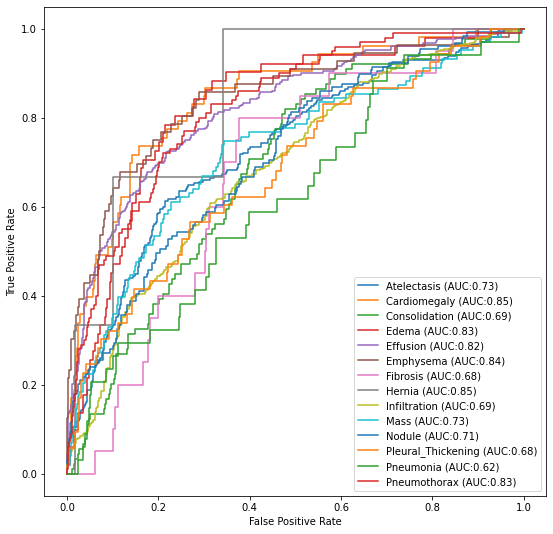

In [112]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [113]:
print('ROC auc score: {:.3f}'.format(roc_auc_score(test_Y.astype(int), y_pred)))

ROC auc score: 0.753
